<img src="film_strip_img.jpg">

# Recommendations for the New Microsoft Movie Studio

Our task is to use data to explore the types of movies that are doing well at the box office, and then make appropriate recommendations to the head of the new studio.  

In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter



%matplotlib inline
sns.set_context('talk')

# Nate's Completed Objectives 

names2 dataframe removed 6783 filmmakers who have died and will be unable to make our movies 

will the remaining names2['primary_profession'] column match up to Manav's crew['writer'] and crew['directors'] columns ?

names2 split primary_profession to access individual professions in the lists

names2 Dropped the now-vacant death_year column

names2 df dropped birth_year col

Discovered that the values in *title2['tconst']* are the same as the values in *akas2['title_id']*

Changed *akas2['title_id']* to *akas['tconst']* to match *title2['tconst'] so we can compare overseas titles and revenue

added .gitignore to our phase-1-group-branch (ignore .ipnb)

dropped any rows outside of Ben's Box-office range of 2015 - 2018 in title2 (from 146,144; down to 67,868)

likewise dropped any rows in akas2 (to 187,981 down from 331,703) not in newly formed title2 with only Ben's years as a range

dropped names2 from 606,648 to 599,685 (6,963 filmmakers who are deceased) 

after successful dropping of any professions other than writer and director in names2 
of writer/director, names2 has 195,828 rows

Printed out a list of strings representing all unique professions under names2.primary_profession
(e.g. producer, director, writer) can add to line of code below to taylor to any of our hiring
needs and wants



## scrapped work

In [5]:
# def format_data(df):
#     for i in range(df.shape[0]):
        
#         df.iat[i,1]= df.iat[i,1].strip(" ")
# format_data(names2)
# names2.head(5)

# s = names2['primary_profession'].apply(lambda x: [z for y in x for z in y.strip(",").lower().split()])

#s = [[z for y in x for z in y.strip(",").lower().split(" ")] for x in names2['primary_profession']]

# changing values in the column from obj to str
#
#names2['primary_profession'] = names2['primary_profession'].astype('str') 
# checking that our entries are strings
#type(names2.loc[0]['primary_profession'])

# # making sure our strings are .lower()
# names2['primary_profession'] = names2['primary_profession'].apply(lambda x : x.lower())
# names2['primary_profession']

# #df[df['A'].str.contains("hello")]
# names2['primary_profession'] = names2['primary_profession'].str.contains("director")
# len(names2)

# drop the old primary_profession column filled with booleans
#names2.drop(['primary_profession'], axis=1, inplace=True)

In [6]:
# trying to get rows from one df that are not in another failure

In [7]:
#     list_ = list_.replace(']', '"]')

In [8]:
##inverse filtering

#value_list = ['miscellaneous', 'production_manager', 'composer', 'music_department', 'sound_department',
      #'miscellaneous', 'actor', '...', 'costume_department', 'costume_designer', 'actress', 'art_director', 'music_department' ]

##have to split the arrays first

#inverse_bool_series = ~names2.primary_profession.isin(value_list)
#names2_filtered = names2[inverse_bool_series]
#names2_filtered

In [9]:
# objective: to strip, clean and seperate names2[primary_profession]
# to find directors and writers and producers that are alive
# who make successful movies
# names2['primary_profession'] = names2['primary_profession'].str.split(",").str[:3]
# names2['primary_profession']
# (names2['primary_profession'][0])
# type(names2['primary_profession'][0][0]) 

In [10]:
# for index, row in names2.iterrows():
#     idx = list(len(range(names2.primary_profession)))
#     for i in idx:
#         print(row['primary_profession'][i])

In [11]:
# for i in range(len(names2)):
#     print(names2.loc[i, 'primary_profession'])

In [12]:
# checks if first row from akas2 is in title2
#title2[title2['tconst'].str.contains("tt0401729")] ## uncomment this line to see what we're looking for
# it is so let's rename the akas2 'title_id' col to tconst for easy matching

In [13]:
# # set the words you want to match.
# matched_words = ['writer', 'writer director', 'director']
# #drop rows which has nan in column 'primary_profession'
# names2 = names2.dropna(axis='index', subset=['primary_profession'])
# #extract all matched words
# names2_extractall = names2['primary_profession'].str.extractall(rf'({"|".join(matched_words)})')
# #groupby index and join those matches result by ','
# mod_prof = names2_extractall.groupby(level=0).apply(lambda x: ",".join(x.iloc[:, 0]))
# #assign to column 'primary_profession'
# names2 = names2.assign(primary_profession=mod_prof)
# #drop no matched rows
# names2 = names2.dropna(axis='index', subset=['primary_profession'])


## End of scrapped work

## Start of Nate Cleaning Data

In [14]:
# load Nate's imdb_dataframes (Manav has other 3 imdb dfs)

crew_imdb = pd.read_csv('imdb.title.crew.csv.gz') # manav'


# nate's 3 dfs
title_basics_imdb = pd.read_csv('imdb.title.basics.csv.gz')
akas_imdb = pd.read_csv('imdb.title.akas.csv.gz')
name_basics_imdb = pd.read_csv('imdb.name.basics.csv.gz')

# renaming the dataframes to make them easier to work with
crew = crew_imdb # manav's df

# nate's 3 dfs with cleaner names
title = title_basics_imdb
akas = akas_imdb
names = name_basics_imdb

FileNotFoundError: [Errno 2] No such file or directory: 'imdb.title.crew.csv.gz'

### making copies of the dataframes for trial and error purposes

In [15]:
# making copies of the original dfs to work on 

title2 = title.copy(deep=True)
title3 = title.copy(deep=True) # the test df for the test df...nan
akas2 = akas.copy(deep=True)
names2 = names.copy(deep=True)
crew2 = crew.copy(deep=True)

NameError: name 'title' is not defined

## Beginning to clean and alter the data frames

In [1179]:
# remove all directors from the names2 df that have died
names2 = names2.loc[names2['death_year'].isna()].reset_index(drop=True)

In [1180]:
# dropped the now-vacant death_year column
names2.drop(['death_year'], axis = 1, inplace=True)
# also dropping the birth_year column
names2.drop(['birth_year'], axis=1, inplace=True)

reasigning the name of the first column in akas2 from title_id to tconst
so title2 and akas2 can be compared more readily

In [1182]:
akas2.rename(columns = {'title_id':'tconst'}, inplace = True)

In [1183]:
# getting rid of any rows outside of Ben's Box-Office dates range of 2015 - 2018
title2 = title2.loc[(title2['start_year'] >= 2015) & (title2['start_year'] <= 2018)]
#title2
# that looks good. Now let's make sure akas2 matches those years
#len(title2)

if akas2['tconst'] not in title2['tconst'] with Ben's range of years, drop those rows in skas2['tconst']
something like:  if akas2['tconst'] not in title2['tconst'] drop akas2['tconst']

In [1184]:
common = akas2.merge(title2, on=["tconst"])
akas2 = result = akas2[~akas2.tconst.isin(common.tconst)]
#len(akas2)

in the above cellthe reason that akas2 has more rows is that 
there are multiple titles in several different
languages, sharing the same tconst label. 
There are, however, no tconst in akas2 
that are not in title2 and vise versa.

steps toward achieving ***first normal form***

In [1185]:
# get rid of any professions other than writer and director or writer/director under primary_profession column
profs = names2['primary_profession'].str.split(',').explode()
filtered_profs = profs[profs.isin(['writer', 'writer director', 'director'])]
filtered_profs.groupby(filtered_profs.index).agg(','.join)
names2 = names2.drop('primary_profession', axis=1).join(filtered_profs.groupby(filtered_profs.index).agg(','.join), how='inner')

### failure at searching for highest grossin films by title

In [1227]:
films = title2['primary_title']
star_wars = films[films.isin(['Star Wars: Episode VII - The Force Awakens'])]
star_wars
title2.loc[41443, :]

tconst                                              tt2488496
primary_title      Star Wars: Episode VII - The Force Awakens
original_title     Star Wars: Episode VII - The Force Awakens
start_year                                               2015
runtime_minutes                                           136
genres                               Action,Adventure,Fantasy
Name: 41443, dtype: object

In [1237]:
# Now we have the tconst of Star Wars: Episode VII. 
# Let's find who the writer's directors were by tconst

extra_directors = names2[names2.known_for_titles.str.contains('tt2488496', na=False)].head(5)

The above list points out that just because we have primary profssion 
narrowed down to writer and director, doesn't mean that when we search for
that tconst under known_for_titles it will return only our desired director.
other actors and producers who worked on star was in that capacity are also 
directors on other projects. Thusly, there name is still associated with the
profession director/writer and returned with our search along with the 
real writer and director

**-----------------------------------------------------------------------------------------------------------------**

In [3]:
title2.head(3)

NameError: name 'title2' is not defined

In [1138]:
akas2.head(10)

,tconst,ordering,title,region,language,types,attributes,is_original_title
48,tt0381957,1,Cloud Cuckoo Land,GB,NaN,NaN,NaN,0.0
49,tt0401729,10,Джон Картер: Мiж двох свiтiв,UA,NaN,NaN,NaN,0.0
50,tt0401729,11,John Carter of Mars,US,NaN,working,NaN,0.0
51,tt0401729,12,A Princess of Mars,US,NaN,working,NaN,0.0
52,tt0401729,13,John Carter - Entre dos mundos,AR,NaN,imdbDisplay,NaN,0.0
53,tt0401729,14,John Carter Maaveeran,IN,ta,NaN,dubbed version,0.0
54,tt0401729,15,Džonas Karteris,LT,NaN,NaN,NaN,0.0
55,tt0401729,16,John Carter,PT,NaN,imdbDisplay,NaN,0.0
56,tt0401729,17,John Carter: Mezi dvěma světy,CZ,NaN,NaN,NaN,0.0
57,tt0401729,18,John Carter: Ανάμεσα σε δύο κόσμους,GR,NaN,NaN,NaN,0.0


In [1139]:
names2.head(10)

,nconst,primary_name,known_for_titles,primary_profession
2,nm0062070,Bruce Baum,"tt1470654,tt0363631,tt0104030,tt0102898",writer
5,nm0062879,Ruel S. Bayani,"tt2590280,tt0352080,tt0216559,tt2057445",director
10,nm0064023,Bryan Beasley,"tt3501180,tt1485100,tt1358897,tt1387162","director,writer"
12,nm0065847,Michael Frost Beckner,"tt0108171,tt0095953,tt0266987,tt0285332",writer
15,nm0066163,Arnaud Bedouët,"tt1355327,tt1977735,tt0173525,tt1710520","writer,director"
16,nm0066268,Steve Mitchell Beebe,"tt0827928,tt0119961,tt0408417,tt5521860",director
18,nm0067234,Hans Beimler,"tt0486657,tt0092455,tt0091129,tt0106145",writer
21,nm0068170,Dylan Bell,"tt4655766,tt3180116,tt8170168,tt4082762",director
23,nm0068874,Hava Kohav Beller,"tt0102778,tt7701650,tt0350668","director,writer"
30,nm0070482,Joel Bender,"tt1454573,tt0077597,tt4637900,tt0424938","director,writer"


Here we have a list of strings representing
all the professions in primary_profession we can choose from this list and apply any names 
we wish to **"get rid of any professional except
writers and directors.. code in the cell above"**
this will return rows with only *producer*, for example.
Then we can correlate the producers with the highest 
grossing films from 2018 (or any other year) by connecting tconst
and (example) nm0001011, symbolizing director and witers, from Manav's crew df 
then secure their employment for the making of our first movies.

In [1141]:
# manav's imdb df with numbers and letters pointing to crew
crew.head(5)

,tconst,directors,writers
0,tt0285252,nm0899854,nm0899854
1,tt0438973,NaN,"nm0175726,nm1802864"
2,tt0462036,nm1940585,nm1940585
3,tt0835418,nm0151540,"nm0310087,nm0841532"
4,tt0878654,"nm0089502,nm2291498,nm2292011",nm0284943


# Start of Nate's Graphs

In [289]:
# Loading Manav's final dataframe
# making a copy of the dataframe and assigning it to
# the variabable cleaner
cleaner_imdb = pd.read_csv('https://raw.githubusercontent.com/nate-walter/phase-1-project-mvp-repo/imdb_branch/Data/imdb_cleaned_final.csv')
cleaner = cleaner_imdb.copy()

In [290]:
# drop duplicates based on tconst redundancies
cleaner.drop_duplicates(subset = "tconst",  inplace = True)

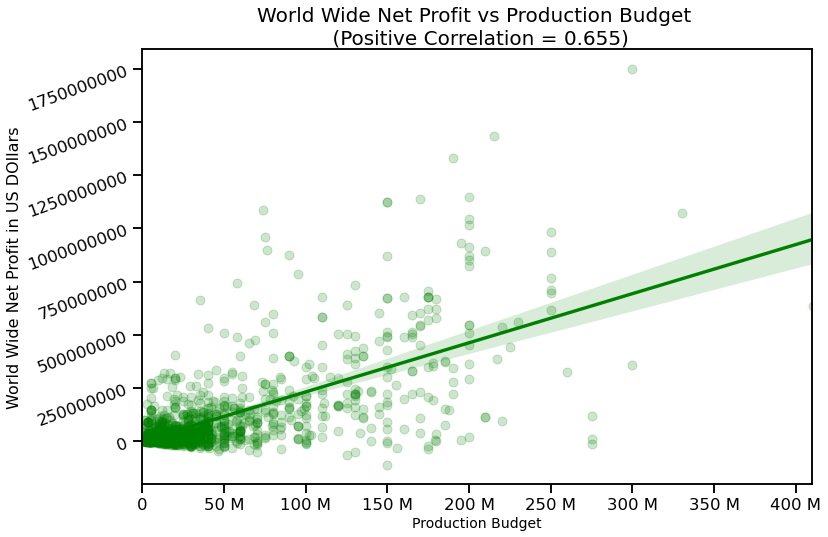

In [380]:
# Scatter plot of production_budget vs Worldwide Net Profit
budget = cleaner['production_budget']
profit = cleaner['Worldwide Net Profit']

fig, ax = plt.subplots(figsize=(12,8))

ax = sns.regplot(x='production_budget', y=profit, data = cleaner, color='green', scatter_kws={'alpha':0.2});


ax.set_facecolor('white')
ax.set_xlabel('Production Budget', size=14)
ax.set_ylabel('World Wide Net Profit in US DOllars', size=16)
ax.set_title('World Wide Net Profit vs Production Budget \n (Positive Correlation = 0.655)', size =20)

ax.set_xlim(0, 410000000)
plt.yticks(rotation=20)


ax.xaxis.set_major_formatter(ticker.EngFormatter())
plt.ticklabel_format(style='plain', axis='y');

In [352]:
#World Wide Net Prof vs Poduction Budget correlation
cleaner['Worldwide Net Profit'].min()#['production_budget']['Worldwide Net Profit']

-110450242

The Production Budget vs Worldwide Net Profits scatter plot (above in green) shows that there seems to be a slightly strong correllation between how much a studio spends on a film and how much it profits on the world market. These figures could be interpeted as the more money spent equals more money accrued. However, it should be taken into account that the highest loss of any film world wide was $110,450,242. As a precaution it may be in the studio's best
interest to not produce all big budget movies in its infancy as a company. Perhaps reference independent studios such
as A24 for ideas on smaller budget productions that make robust profits, earn fans' admiration, while maintaining artistic integrity. 

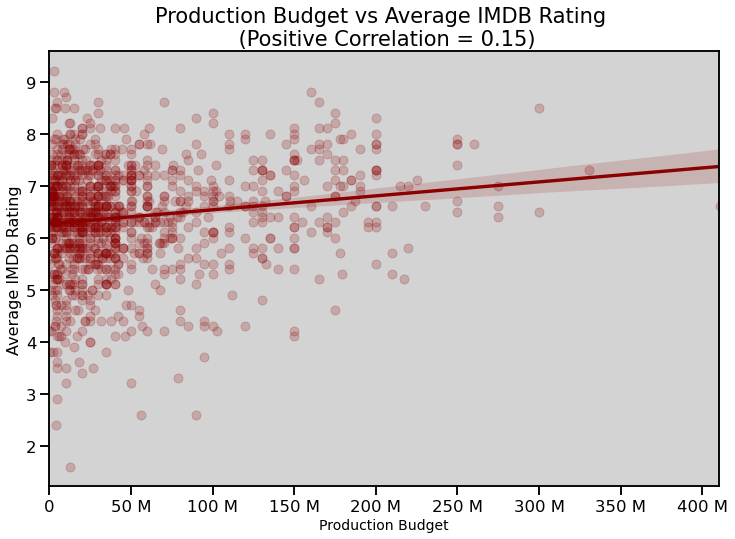

In [379]:
#Scatter plot of production_budget vs averagerating

rating = cleaner['averagerating']

fig, ax = plt.subplots(figsize=(12,8))

sns.regplot(x=budget, y=rating, data = cleaner, color='darkred', scatter_kws={'alpha':0.2})

ax.set_facecolor('lightgrey')
ax.set_xlabel('Production Budget',size=14)
ax.set_ylabel('Average IMDb Rating', size=16)
ax.set_title('Production Budget vs Average IMDB Rating \n (Positive Correlation = 0.15)', size =21)
ax.set_xlim(0, 410000000)
ax.xaxis.set_major_formatter(ticker.EngFormatter());

In [158]:
cleaner.corr()['production_budget']['averagerating']

0.15091492158356226

The Production Budget vs Average IMDB Rating coupled with the correlation figures show that there is very low 
positive correlation between production budget and IMDb ratings. 
Therefore, decisions on which films to make should not be based 
upon IMDb reviews. As much as Twitter might have you believe.

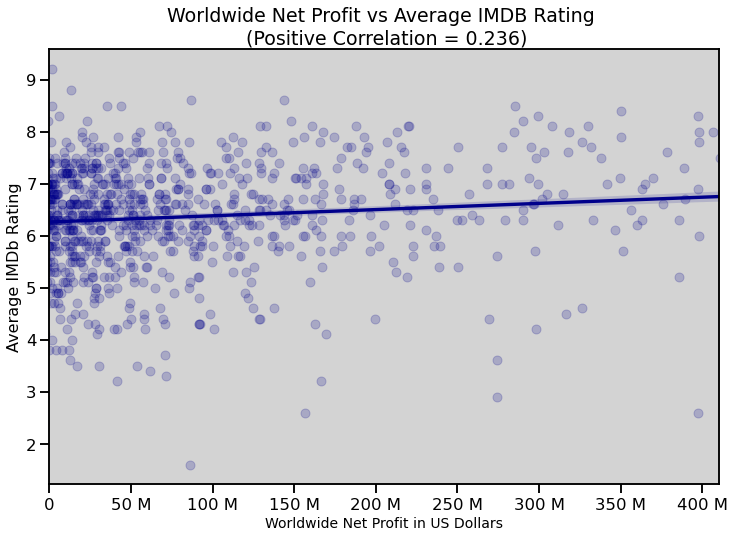

In [381]:
fig, ax = plt.subplots(figsize=(12,8))

sns.regplot(x=profit, y=rating, data = cleaner, color='darkblue', scatter_kws={'alpha':0.2})

ax.set_facecolor('lightgrey')
ax.set_xlabel('Worldwide Net Profit in US Dollars',size=14)
ax.set_ylabel('Average IMDb Rating', size=16)
ax.set_title('Worldwide Net Profit vs Average IMDB Rating \n (Positive Correlation = 0.236)', size =19)
ax.set_xlim(0, 410000000)
ax.xaxis.set_major_formatter(ticker.EngFormatter());

In [340]:
cleaner.corr()['Worldwide Net Profit']['averagerating']

0.2361185196365939

The Worldwide Net Profit vs Average IMDb Rating scatter plot along with the correlation calculation 
shows that there is a low positive correlation between Net Profit and user ratings. It is however, slightly 
higher than the correlation between Production Budget and Average IMDb rating. This could be due to more people
paying to see the films or repeated viewings which would, one could surmise, lead to more favorable reviews.